# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [1]:
!pip install -U -q scikit-learn
!pip install -U -q seaborn

In [2]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from scipy.spatial import distance

from sklearn.model_selection import train_test_split

from IPython.display import display

from sklearn.utils import shuffle

In [3]:
RANDOM_VAR = 2128506

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [4]:
pathIOS = '/Users/stainer/Desktop/Jupyter/Project_15 Linear Algebra'
pathWIN = 'C:/Users/techn/Desktop/Practicum100 - Jupiter/Project_15 Linear Algebra'
try:
    df = pd.read_csv('/datasets/insurance_us.csv')
except:
    try:
        df = pd.read_csv(pathWIN+'/insurance_us.csv')
    except:
        df = pd.read_csv(pathIOS+'/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [5]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [6]:
df.sample(10)

In [7]:
df.info()

In [8]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df.age = df.age.astype('int')

In [9]:
# check to see that the conversion was successful
df.info()

In [10]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [11]:
df.isnull().sum()

In [12]:
print(f"We found {df.duplicated().sum()} duplicated entries. It's {df.duplicated().sum() / df.shape[0]:.3%} of our data set")
display(df[df.duplicated()])

We've found no missing values and 153 duplicated entries. \
Even if it does not seem improbable that we had multiple records of someone, let's say 39 years of age, male, alone and with income of 48100. But let's play safe and remove those entries

In [13]:
df.drop_duplicates(inplace=True)

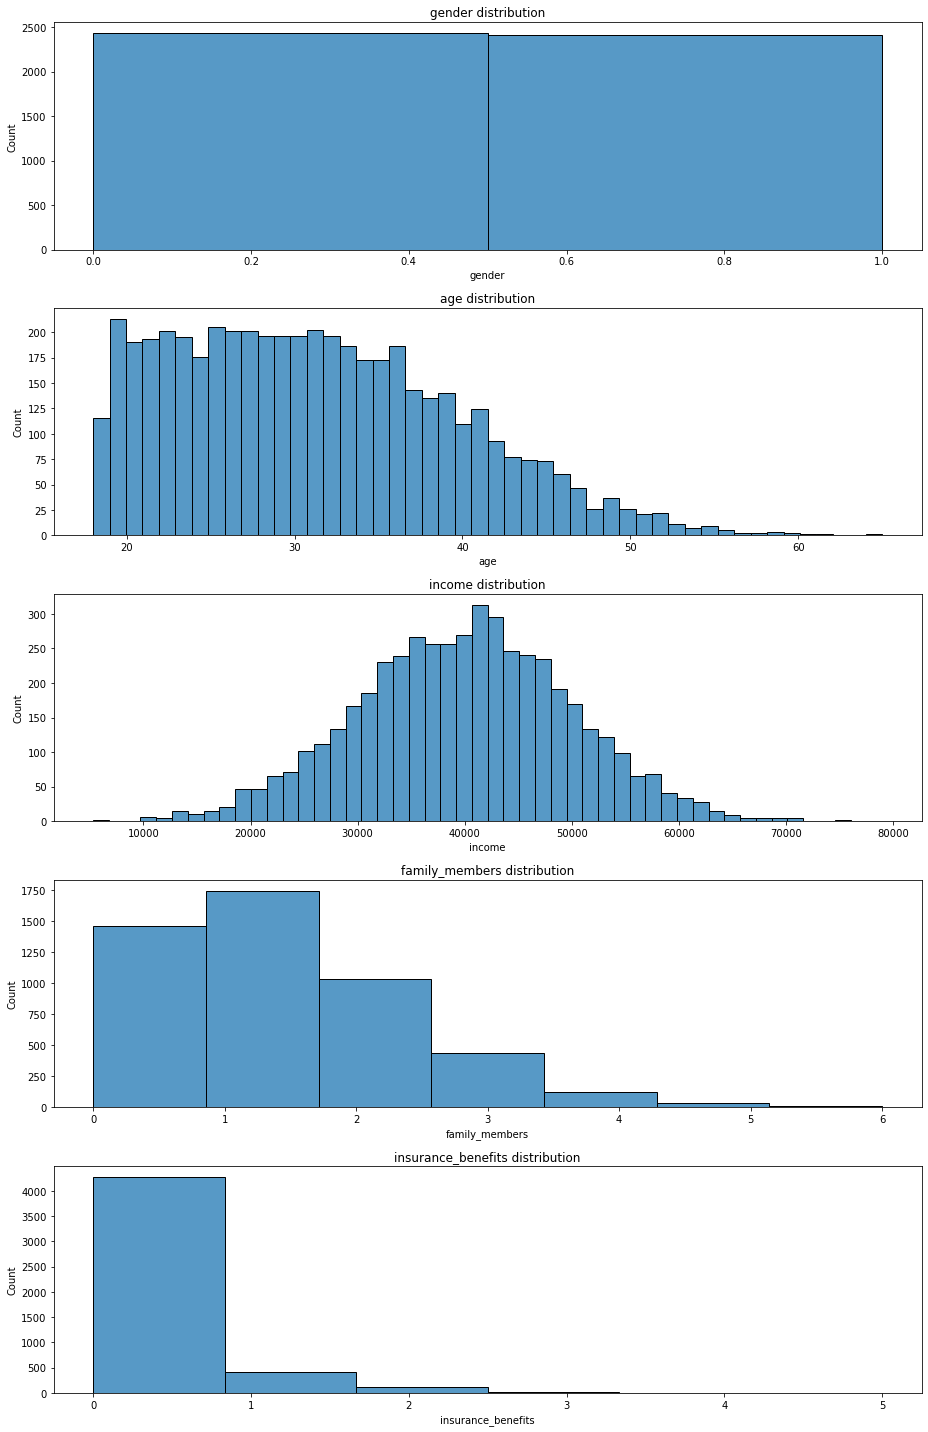

In [14]:
fig, axes = plt.subplots(nrows=len(df.columns), ncols=1, figsize=(13,20))
for index, column in enumerate(df.columns):
    sns.histplot(df[column],ax=axes[index], bins = min(50, df[column].max() - df[column].min() + 1))
    axes[index].set_title(column + ' distribution')
plt.tight_layout()   

__Summary:__
- We've found no missing values
- ~3% of entries are duplicated. We played safe and removed them
- Data distribution seems normal. 
    - Equal number of males and females 
    - Number of customers gradually decreseases as their age increases.
    - Income destirbuted normaly
    - Most of the customers did not recieve insurance benefits

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

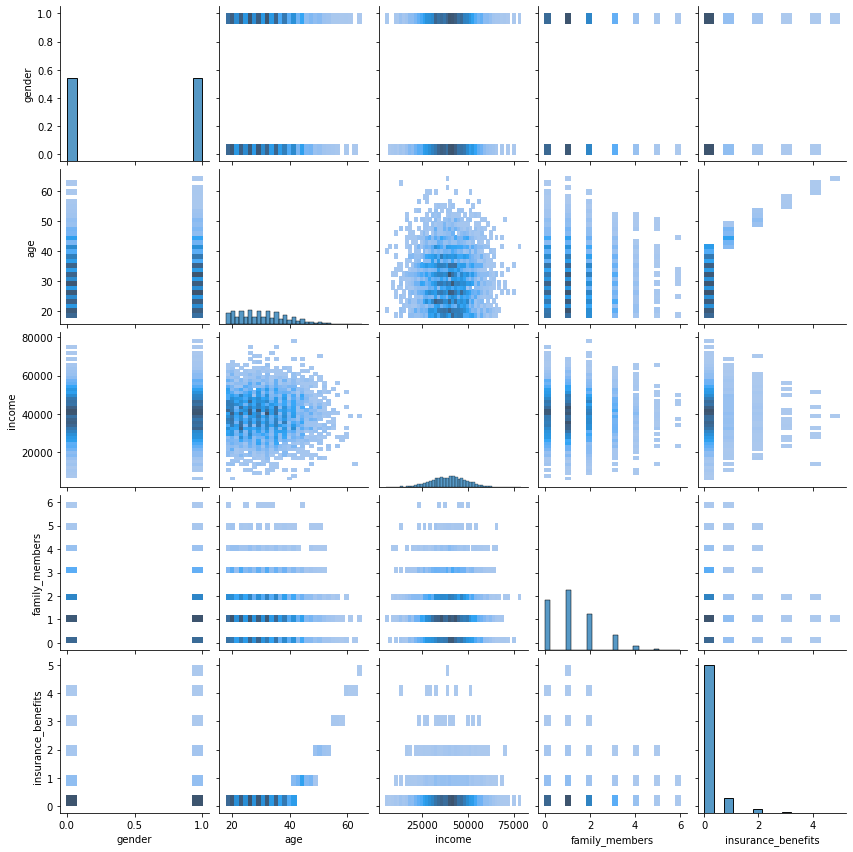

In [15]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
class K_Neighbors():
    '''
        param : metric method of calculating distance
    '''
    def __init__(self, metric):
        self.metric = metric
        if metric == distance.euclidean:
            self.neighbors_metric = self.kneighbors_euclidean
        else:
            self.neighbors_metric = self.kneighbors_manhattan
    
    def fit(self,features, target):
        self.features = features
        self.target = target
        
    def kneighbors_euclidean(self, for_entrie, n_neighbors):
#         calculates euclidean distance and returns n-closest to passed entrie
        entrie_vector = for_entrie.values
        distances = self.features.values
        distances = distances - entrie_vector
        distances = distances * distances
        distances = distances.dot(np.array([1]*len(feature_names)))
#         distances = distances**0.5
#         this step can be skipped, if we only need to compare distances but not retuen them
        return distances.argsort()[1:n_neighbors+1]
        
    def kneighbors_manhattan(self, for_entrie, n_neighbors):
#         calculates manhattan distance and returns n-closest to passed entrie
        entrie_vector = for_entrie.values
        distances = self.features.values
        distances = distances - entrie_vector
        distances = np.abs(distances)
        distances = distances.dot(np.array([1]*len(feature_names)))
        return distances.argsort()[1:n_neighbors+1]
        
    def kneighbors(self, for_entrie, n_neighbors, with_return_distance=False):
#         This was writen first, and I didn't think at first of matrices
#         could re-write this to use matric multiplication, but it's not used afanywhere aside from get_knn
#         function, so I left it like this. Probably will fix later
        entrie_vector = np.array(for_entrie)
        distances = []
        for index in range(len(self.features)):
            dist = self.metric(self.features.iloc[index].values, entrie_vector)
            distances.append(dist)
        distances_vector = np.array(distances)
        neghbor_index = distances_vector.argsort()[1:n_neighbors+1]
        neighbor_dist = distances_vector[neghbor_index]
        if with_return_distance:
            return (neighbor_dist, neghbor_index)
        else:
            return neghbor_index
        
    def predict(self, test_features, n_neighbors):
        predictions = []
        for index in range(len(test_features)):
#             print(index)
            item = test_features.iloc[index]
            neighbors = self.neighbors_metric(item, n_neighbors)
#             print(neighbors)
            neighbor_target = self.target.values[neighbors]
#             print(neighbor_target)
            predictions.append(np.mean(neighbor_target).round())
        predictions_set = pd.Series(predictions, index=test_features.index)
        return predictions_set

In [18]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = K_Neighbors(metric)
    nbrs.fit(df[feature_names], df.drop(feature_names, axis=1)) 
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, with_return_distance=True)
    
    df_res = pd.DataFrame(nbrs_distances, index=nbrs_indices, columns=['distance'])
    
    return df_res

Scaling the data.

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [20]:
df_scaled.sample(5)

Now, let's get similar records for a given one for every combination

In [21]:
# We'll pick random entrie and display nearest neighbors indexes and distance from them
index = np.random.randint(0, len(df))
n_neighbors = 5
euclid = get_knn(df, index, n_neighbors, distance.euclidean)
euclid_scaled = get_knn(df_scaled, index, n_neighbors, distance.euclidean)
manhat = get_knn(df, index, n_neighbors, distance.cityblock)
manhat_scaled = get_knn(df_scaled, index, n_neighbors, distance.cityblock)

In [22]:
euclid.reset_index().join(euclid_scaled.reset_index(), rsuffix='_scaled').join(manhat.reset_index(), rsuffix='_manhattan').join(manhat_scaled.reset_index(), rsuffix='_manhattan_scaled')

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

It does! We have completely different results for pure and scaled data with bot methods. \
This happens because features have different range and similar relative difference can differently affect distance metric if not scaled

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Results are very similar.

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [23]:
# calculate the target

df['insurance_benefits_received'] = (df.insurance_benefits / df.insurance_benefits.max()).apply(np.ceil).astype('int')

In [24]:
# check for the class imbalance with value_counts()
df['insurance_benefits_received'].value_counts()

# <your code here>

In [25]:
# On second thought that seems like a bad idea to upscale data. 
# If the closest neighbor would be of underrepresented class, latter neighbors would be it's exact copies

# # function returns upscaled and shuffled features and target data sets
# def upsample_set(features, features_scaled, target, repeat):
#     # Split by class
#     features_true = features[target==1]
#     features_false = features[target==0]
#     features_scaled_true = features_scaled[target==1]
#     features_scaled_false = features_scaled[target==0]
#     target_true = target[target==1]
#     target_false = target[target==0]
#     # Repeat underrepresented class and join with the second class
#     features_upsampled = pd.concat([features_false] + [features_true] * repeat)
#     features_scaled_upsampled = pd.concat([features_scaled_false] + [features_scaled_true] * repeat)
#     target_upsampled = pd.concat([target_false] + [target_true] * repeat)
#     # Shuffle and return
#     features_upsampled, features_scaled_upsampled, target_upsampled = shuffle(features_upsampled, features_scaled_upsampled, target_upsampled, random_state=RANDOM_VAR)
#     return features_upsampled, features_scaled_upsampled, target_upsampled

In [26]:
features = df[feature_names]
target = df.insurance_benefits_received

In [27]:
# def downsample(features, target):
# #     print(features.shape, features_scaled.shape, target.shape)
#     features_ones = features[target==1]
#     features_zeros = features[target==0]
#     fraction = len(features_ones) / len(features_zeros)
#     target_ones = target[target==1]
#     target_zeros = target[target==0]
#     features_downsampled = pd.concat(
#         [features_zeros.sample(frac=fraction, random_state=RANDOM_VAR)] + [features_ones]
#     )
#     target_downsampled = pd.concat(
#         [target_zeros.sample(frac=fraction, random_state=RANDOM_VAR)] + [target_ones]
#     )
#     features_downsampled, target_downsampled = shuffle(
#             features_downsampled, target_downsampled, random_state=RANDOM_VAR
#         )
#     return features_downsampled, target_downsampled

# # features_downsampled, target_downsample = downsample(features, target)
# # features_downsampled

In [28]:
def downsample(features_list, target):
    target_zeros = target[target==0]
    target_ones = target[target==1]
    fraction = len(target_ones) / len(target_zeros)
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_VAR)] + [target_ones]
    )
    target_downsampled = shuffle(
            target_downsampled, random_state=RANDOM_VAR
        )
    downsampled_features_list = []
    for features in features_list:
        features_ones = features[target==1]
        features_zeros = features[target==0]
#         display(features.head(), features_ones.head(), features_zeros.head())
        features_downsampled = pd.concat(
            [features_zeros.sample(frac=fraction, random_state=RANDOM_VAR)] + [features_ones]
        )
        downsampled_features_list.append(shuffle(features_downsampled, random_state=RANDOM_VAR))
    return downsampled_features_list, target_downsampled
    

In [29]:
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.3, random_state=RANDOM_VAR)

feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(train_features)

train_features_scaled = pd.DataFrame(transformer_mas.transform(train_features), index=train_features.index, columns=train_features.columns)
test_features_scaled = pd.DataFrame(transformer_mas.transform(test_features), index=test_features.index, columns=test_features.columns)

In [30]:
[train_features_downsampled, train_features_scaled_downsampled], train_target_downsampled = downsample([train_features, train_features_scaled], train_target)

In [32]:
def eval_classifier(y_true, y_pred, with_output=True):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    if with_output:
        print(f'F1: {f1_score:.2f}')
        print('Confusion Matrix')
        print(cm)
    return f1_score

In [33]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [34]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df)) 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

In [35]:
variants = [
    {
        'train_features':train_features, 
        'train_target':train_target,
        'test_features':test_features, 
        'test_target':test_target,
        'method':distance.euclidean, 
        'name':'Unscaled data, euclidean distance'},
    {
        'train_features':train_features_scaled, 
        'train_target':train_target,
        'test_features':test_features_scaled, 
        'test_target':test_target,
        'method':distance.euclidean,
        'name':'Scaled data, euclidean distance'},
    {
        'train_features':train_features_downsampled, 
        'train_target':train_target_downsampled,
        'test_features':test_features,
        'test_target':test_target,
        'method':distance.euclidean, 
        'name':'Downsampled unscaled data, euclidean distance'},
    {
        'train_features':train_features_scaled_downsampled, 
        'train_target':train_target_downsampled,
        'test_features':test_features_scaled, 
        'test_target':test_target,
        'method':distance.euclidean,
        'name':'Downsampled scaled data, euclidean distance'},
    {
        'train_features':train_features,
        'train_target':train_target,
        'test_features':test_features,
        'test_target':test_target,
        'method':distance.cityblock, 
        'name':'Unscaled data, manhattan distance'},
    {
        'train_features':train_features_scaled, 
        'train_target':train_target,
        'test_features':test_features_scaled,
        'test_target':test_target,
        'method':distance.cityblock, 
        'name':'Scaled data, manhattan distance'},
    {
        'train_features':train_features_downsampled, 
        'train_target':train_target_downsampled,
        'test_features':test_features,
        'test_target':test_target,
        'method':distance.cityblock, 
        'name':'Downspled unscaled data, manhattan distance'},
    {
        'train_features':train_features_scaled_downsampled, 
        'train_target':train_target_downsampled,
        'test_features':test_features_scaled, 
        'test_target':test_target,
        'method':distance.cityblock, 
        'name':'Downsampled scaled data, manhattan distance'}
      ]

In [36]:
table = []
for n_neighbors in range(1,11):
    row = []
    for variant in variants:
        knm = K_Neighbors(variant['method'])
        knm.fit(variant['train_features'], variant['train_target'])
        predictions = knm.predict(variant['test_features'], n_neighbors)
#         We have a lot of variants here, I will mute evaluation output so it will not clutter the notebook
#         Instead I will gather f1 scaores into a table
#         print(variant['name']+f' with {n_neighbors} neighbors')
        f1_score = eval_classifier(variant['test_target'], predictions, with_output=False)
        row.append(f1_score)
    table.append(row)

In [37]:
pd.DataFrame(table, index=range(1,11), columns=['ecld_pure', 'ecld_scld', 'ecld_dn', 'ecld_dn_scld','mnht_pure', 'mnht_scld', 'mnht_dn', 'mnht_dn_scld'])


__Summary:__
- Distance metric does not have huge impact on models performance
- Even with unscaled, unbalanced data, model achieves f1 score on par with dummy model
- Scaling data helps greatly to detect "real" neighbors
- Dealing with class imbalance further improves models performance. Upsampling seemed like a bad idea, as we could get copies of same entrie as nearest neighbor
- Model performance suffers when dealing with unscaled, unbalanced data with high number of neighbors, while working with processed data it stays more or less same

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [38]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        
    def predict(self, X):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2.dot(self.weights)
        
        return y_pred

In [39]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    try:
#         In the precode there was a square root around r2_score. Why? 
        r2_score = sklearn.metrics.r2_score(y_true, y_pred)
        print(f'R2: {r2_score:.2f}')    
    except:
        print(f'Could not calculate R2 = {sklearn.metrics.r2_score(y_true, y_pred):.10f}')

In [71]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)
lr = MyLinearRegression()

display(pd.DataFrame(X_train).head())

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

In [41]:
dummy = np.array([df['insurance_benefits'].mean()]*len(y_test))
eval_regressor(y_test, dummy)

__Summary:__
Linear regression model works, and achieves lower mean error score than our dummy models

In [65]:
def features_scaler(train_features, test_features):
    transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(train_features)
    train_features_scaled = transformer_mas.transform(train_features)
    test_features_scaled = transformer_mas.transform(test_features)
    return train_features_scaled, test_features_scaled

In [73]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

X_train, X_test = features_scaler(X_train, X_test)

display(pd.DataFrame(X_train).head())

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

__Summary:__
It seems like data scaling had no effect on models performance. That was unexpected.\
However maybe it has something to do with the fact that obfuscating works with linear regression model

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [43]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]
df_pn.head()

In [44]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [45]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [46]:
try:
    P_inv = np.linalg.inv(P)
    print(P_inv)
except:
    print('Matrix is not invertible')

Can you guess the customers' ages or income after the transformation?

In [47]:
X_obf = X.dot(P)
pd.DataFrame(X_obf, columns=df_pn.columns, index=df_pn.index).head()

Not really :)

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [48]:
pd.DataFrame(X_obf.dot(P_inv), columns=df_pn.columns, index=df_pn.index).head().round()

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [49]:
display(df_pn.head(), pd.DataFrame(X_obf, columns=df_pn.columns, index=df_pn.index).head(), pd.DataFrame(X_obf.dot(P_inv), columns=df_pn.columns, index=df_pn.index).head().round())

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Machines use floating point numbers and part of the data got cut in the process due to memory restrictions.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

\begin{align*}
w &= (X^{T}X)^{-1}X^{T}y & w_p &= [(XP)^T XP]^{-1}(XP)^T y \\
w &= X^{-1}(X^{T})^{-1}X^{T}y & w_p &= [(P^{T} X^{T})(XP)]^{-1}P^{T}X^{T}y \\
w &= X^{-1}Iy & w_p &= (XP)^{-1}(P^{T} X^{T})^{-1}(P^{T}X^{T})y \\ 
w &= X^{-1}y & w_p &= P^{-1}X^{-1}y \\
&& w_p &= P^{-1}w \\
\\
y_{p\_pred} &= X_{p\_val}w_p = X_{p\_val}P^{-1}w = X_{val}PP^{-1}w = X_{val}w
\end{align*}

**Analytical proof**

Weights that we get with obfuscated train features matrix $P^{-1}w$.\
When we pass obfuscated test features matrix we get $X_{val}PP^{-1}w$. \
Because $PP^{-1} = I$ resulting predicted values will be equal to those we got whith pure data

\begin{align*}
w_p &= ((XP)^T XP)^{-1} (XP)^{-1}y \\
w_p &= (P^T(X^T X) P)^{-1} P^T X^T y \\
w_p &= P^{-1} (X^T X)^{-1} {P^T}^{-1} P^T X^T y \\
w_p &= P^{-1} (X^T X)^{-1} I X^T y = P^{-1}w
\end{align*}

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [50]:
class Obfuscated_LR(MyLinearRegression):
    obfuscation_matrix = np.array([])
    def __init__(self, matrix=np.array([])):
        super().__init__()
        self.obfuscation_matrix = matrix
    
    def fit(self, features, target):
        if self.obfuscation_matrix.any():
            super().fit(features.dot(self.obfuscation_matrix), target)
        else:
            super().fit(features, target)
            
    def predict(self, features):
        if self.obfuscation_matrix.any():
            return super().predict(features.dot(self.obfuscation_matrix))
        else:
            return super().predict(features)

In [51]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

rng = np.random.default_rng()
P = np.array([])
while not P.any():
    try:
        P = rng.random(size=(X_train.shape[1], X_train.shape[1]))
        P_inv = np.linalg.inv(P)
    except:
        print('Matrix is not invertible')

print('Model performance with obfuscated data')
lr = Obfuscated_LR(matrix=P)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
eval_regressor(y_test, y_pred)

print('\nModel performance with pure data')
lro = Obfuscated_LR()
lro.fit(X_train, y_train)
y_pred_o = lro.predict(X_test)
eval_regressor(y_test, y_pred_o)

# Conclusions

- We've examined recieved data for errors. 
    - Didn't find missing values
    - Removed 153 duplicating values (~3% of data).
    - Looked at features distribution
- Wrote procedures for calculation of n-nearest neighbors of entrie in the table, and later used in in procedure that will predict target value based on values of nearest neighbors
    - Evaluated this model with different numbr of neighbors, distance metric (euclidean and manhattan) and different states of data(balanced/ unbalanced, scaled/not scaled)
    - Summarized recieved f1 scores into a table
- Implemented Linear regression solution
    - Evaluated it with RMSE and R2 scores, compared to a dummy model
- Investigated possibilities of obfuscating data using matrix multiplication
    - Generated invertible matrix and obfuscated data
    - Recovered initial data from obfuscated one
    - Proved that this process would not affect our ability to train working linear regression model and evaluate its' performance
- Overall we dipped our toe into a huge ocean of complex procedures, models, linear algebra etc. Moving forward :)

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells are arranged in order of logic and execution
- [x]  Task 1 has been performed
    - [x]  There is the procedure that can return k similar customers for a given one
    - [x]  The procedure is tested for all four proposed combinations
    - [x]  The questions re the scaling/distances are answered
- [x]  Task 2 has been performed
    - [x]  The random classification model is built and tested for all for probability levels
    - [x]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [x]  Task 3 has been performed
    - [x]  The linear tegression solution is implemented with matrix operations.
    - [x]  RMSE is calculated for the implemented solution.
- [x]  Task 4 has been performed
    - [x]  The data is obfuscated with a random and invertible matrix P
    - [x]  The obfuscated data is recoved, few examples are printed out
    - [x]  The analytical proof that the transformation does not affect RMSE is provided 
    - [x]  The computational proof that the transformation does not affect RMSE is provided
- [x]  Conclusions have been made

# Appendices 

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>